In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
tqdm.monitor_interval = 0
import torch
import torch.nn as nn
import numpy as np
torch.manual_seed(0)
np.random.seed(0)

In [8]:
FORECAST = 5
EPS = 120
LAG = 12
SROUTE = SAMPLE_ROUTES[0]
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

In [9]:
dset = SingleStop(SROUTE, 30, 'train', 32, lag=LAG).generator()
evalset = SingleStop(SROUTE, 30, 'test', 32, lag=LAG).generator()

Locals dataset: train
 [*] Loaded routes: 1 (0.36s)
 [*] Has trainable inds: 262262
 [*] Subset train: 212106
 [*] Subset in Stop-30: 6079
Locals dataset: test
 [*] Loaded routes: 1 (0.30s)
 [*] Has trainable inds: 262262
 [*] Subset test: 50156
 [*] Subset in Stop-30: 1549


In [22]:
yavg = SingleStop(SROUTE, 30, 'train', 32, lag=LAG).yavg()
print('Y-avg:', yavg)

Locals dataset: train
 [*] Loaded routes: 1 (0.43s)
 [*] Has trainable inds: 262262
 [*] Subset train: 212106
 [*] Subset in Stop-30: 6079
Y-avg: 3.4391126863581287


In [23]:
from models.Linear import Linear

In [24]:
model = Linear(lag=LAG-1).to(device)
model.device = device

In [25]:
criterion, opt, sch = model.params(lr=0.001)

In [26]:
evaluate(evalset, model, crit=lambda _y, y: wape(tonpy(_y)[:, 4], tonpy(y)[:, 4], yavg))
evaluate(evalset, model, crit=lambda _y, y: criterion(_y[:, 4], y[:, 4]).item())

Eval loss: 71.7994   
Eval loss: 12.1071   


In [28]:
losses = []
eval_losses = []
for eii  in range(EPS):
    for bii, batch in enumerate(dset):
        model.train()
        Xs, Ys = model.format_batch(batch)
        outputs = model(Xs)

        opt.zero_grad()
        loss = criterion(outputs, Ys)
        loss.backward()
        losses.append(loss.item())
        opt.step()

        sys.stdout.write('[%d/%d : %d/%d] - L%.2f      \r' % (
            eii+1, EPS,
            bii+1, len(dset), 
            loss.item()
        ))
    sys.stdout.write('\n')

    evaluate(evalset, model, crit=lambda _y, y: wape(tonpy(_y)[:, 4], tonpy(y)[:, 4], yavg))
    evaluate(evalset, model, crit=lambda _y, y: criterion(_y[:, 4], y[:, 4]).item())
#     torch.save(model.state_dict(), 'checkpoints/%s_e%d.pth' % (model.name, eii+1))
    sys.stdout.flush()
    sch.step()

[1/120 : 189/189] - L2.90       
Eval loss: 33.0765   
Eval loss: 3.5858    
[2/120 : 189/189] - L3.14       
Eval loss: 31.6100   
Eval loss: 3.6383    
[3/120 : 189/189] - L2.76       
Eval loss: 30.9775   
Eval loss: 3.4353    
[4/120 : 189/189] - L1.76       
Eval loss: 31.3114   
Eval loss: 3.3647    
[5/120 : 189/189] - L2.14       
Eval loss: 30.6085   
Eval loss: 3.3747    
[6/120 : 189/189] - L2.83       
Eval loss: 30.4589   
Eval loss: 3.3826    
[7/120 : 189/189] - L1.61       
Eval loss: 30.5771   
Eval loss: 3.3362    
[8/120 : 189/189] - L17.13      
Eval loss: 30.3859   
Eval loss: 3.3531    
[9/120 : 189/189] - L3.24       
Eval loss: 30.4018   
Eval loss: 3.3386    
[10/120 : 189/189] - L2.44       
Eval loss: 30.4323   
Eval loss: 3.3299    
[11/120 : 189/189] - L2.87       
Eval loss: 30.4879   
Eval loss: 3.3209    
[12/120 : 189/189] - L1.85       
Eval loss: 30.3703   
Eval loss: 3.3310    
[13/120 : 189/189] - L1.60       
Eval loss: 30.3610   
Eval loss: 3.3300

KeyboardInterrupt: 

2047


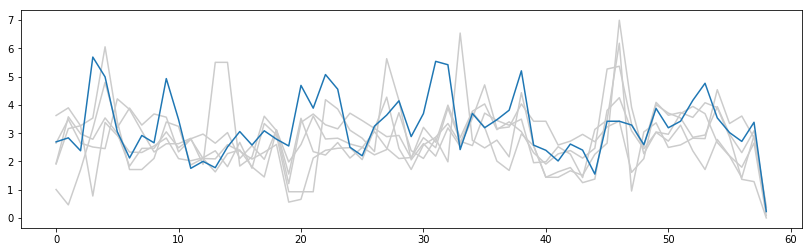

In [10]:
data = history_byname(SROUTE)

sample = data[int(TSTEPS*0.8):]
inds, integs = high_integ(sample[LAG:])
inds += LAG
print(inds[0])
sample = sample[inds[0]-LAG:inds[0]]
for jj, ii in zip(*np.where(np.isnan(sample))):
    sample[jj, ii] = sample[jj-1, ii]
show_context(sample)

In [14]:
# preds = []
# for bi in range(10, sample.shape[1]+1):
bi = 30
hist = sample[:, bi-10:bi]
hist = np.expand_dims(hist, 0)
hist = torch.from_numpy(hist).to(device).float()
Xs, _ = model.format_batch(hist)

yout = model(Xs)
# preds.append(tonpy(yout))

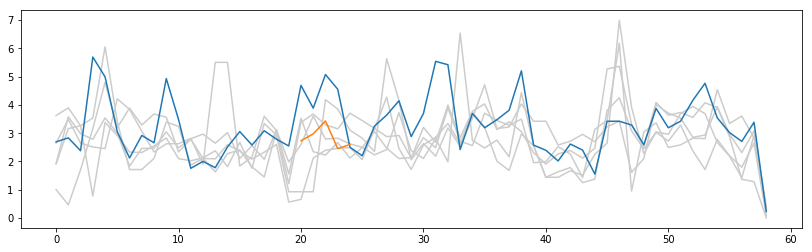

In [15]:
show_context(sample, draw=False)
# for bi in range(10, sample.shape[1]+1, 5):
ylast = preds[bi-10][0]
xpos = range(20, 25)
plt.plot(xpos, ylast, color='C1')

plt.show(); plt.close()